    # Saliency Maps (Image)

In this notebook, you will apply three XAI techniques to derive saliency/attribution maps for a vision model trained to distinguish and classify 1,000 different classes. The maps should then be overlaid on the original image like a heatmap to highlight the regions of the image the model focused on for its classification decision. The model is a high-performing pre-trained Inception network, `inception_v4.pth`. You will find the model and numpy files for images and labels corresponding to four color images of shape $(299 \times 299)$ on moodle. By the end of these exercises, you should be able to appreciate the wide variety of techniques available, as well as their particular hyperparameter sensitivities.

-------------------------

**Integrated Gradients**  
1. Use your theoretical knowledge of Integrated Gradients to write a simple attribution method that returns a saliency map.
2. Explain the purpose of the prefactor $(x_i-x'_i)$ in the formula for Integrated Gradients.
3. Plot the saliency maps for all images.
4. Change the baseline and comment on the results, do they change?
5. Suggest an explanation for your observation if the results are different and suggest an alternative method.
6. Compare your results by implementing Captum's `IntegratedGradients` method.

**Occlusion**
1. Use Captum's built-in occlusion functionality to derive and plot saliency maps for all images.
2. Analyze how different window sizes affect your results and discuss how you would determine the optimal size.

**Grad-CAM**
1. Use your theoretical knowledge of Grad-CAM to write a simple attribution method that returns a saliency map. 
2. Plot the saliency maps for all images.
3. Use a few different target layers and report on how the saliency map changes with model depth.
4. Compare your results by implementing Captum's `LayerGradCam` method.

-------------------------

In [2]:
# Load necessary libraries

import utils  # set of helper functions
import torch  # pytorch for deep learning
import cv2  # opencv for image manipulation
import numpy as np  # numpy for matrix operations
import matplotlib.pyplot as plt  # matplotlib for plotting
from utils import custom_cmap  # custom color map for visualizing attributions
from captum.attr import LayerGradCam, Occlusion, IntegratedGradients  # captum built in attribution methods
import warnings  # to suppress warnings

warnings.filterwarnings("ignore")  # ignore warnings

In [3]:
# Load the pre-trained inception_v4 model and set it to evaluation mode
model = torch.load("./inception_v4.pth")
model.eval();

In [4]:
# load images 
images = np.load('./images.npy')  # images are 299 by 299 and normalize dbetween -1 and 1
# Load corresponding labels
labels = np.load('./labels.npy')
print(images.shape, labels.shape)

(4, 299, 299, 3) (4,)


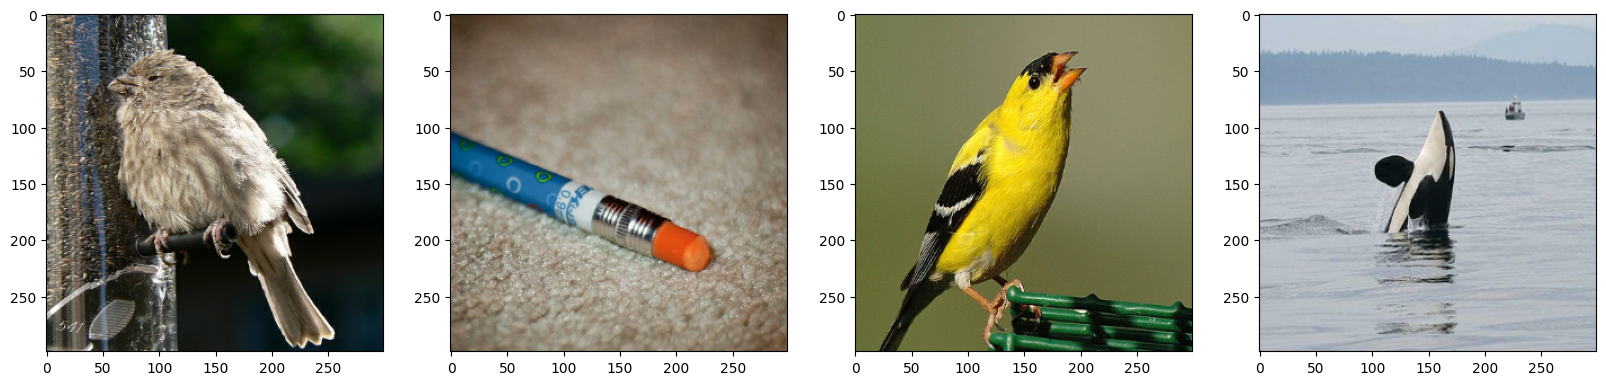

In [5]:
# Plot all normalized images using utils function so the images look good
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i in range(images.shape[0]):
    axs[i].imshow(utils.normalize(images[i]))

<div style="font-size: 10px;">

```python
# You can use the following pattern to plot your attribution results for all images:

fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5)) 

for i, image in enumerate(images):

    # Convert your numpy image to a PyTorch tensor of shape (1, C, H, W)
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()

    # The target class label for the corresponding image
    target_class = int(labels[i])
   
    # Your function or library call here to compute the saliency map
    # -----------------------------------------------------------------

    saliency_map = your_attribution_method(model, target_label)

    # -----------------------------------------------------------------

    # Turn into numpy array and detach if necessary

    # Average over color channels if necessary

    # plot original image if necessary and saliency_map
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(utils.normalize(saliency_map), cmap='some color map', alpha=0.3)
```
</div>

## Integrated Gradients

**1 | Use your theoretical knowledge of Integrated Gradients to write a simple attribution method that returns a saliency map.**

In [5]:
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    # Scale input by creating a set of images lineraly interpolated between the baseline and the input

    scaled_inputs = [baseline + (float(i) / steps) * (input_tensor - baseline) for i in range(steps + 1)]

    grads = []  # list to store gradients at each scaled input
    for scaled_input in scaled_inputs:
        scaled_input = scaled_input.requires_grad_(True)  # Enable gradient computation
        model.zero_grad()  # Clear any existing gradients

        # Forward pass to compute model output
        output = model(scaled_input)
        target_output = output[0, target_class]  # Select the target class score

        # Backward pass to compute gradients of the output w.r.t. the input
        target_output.backward()

        grads.append(scaled_input.grad.detach().cpu().numpy())

    # Approximate the integral of gradients using the trapezoidal rule
    grads = np.array(grads)  # convert to numpy array
    avg_grads = (grads[:-1] + grads[1:]) / 2.0  # average gradients at each step of the integral
    integrated_grads = (input_tensor.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * np.mean(avg_grads,
                                                                                                         axis=0)  # compute the integral

    return integrated_grads

**2 | Explain the purpose of the prefactor $(x_i-x'_i)$ in the formula for Integrated Gradients**

It represents the difference between the input feature value $x_i$  and the baseline feature value  $x'_i$.

**3 | Plot the saliency maps for all images.**

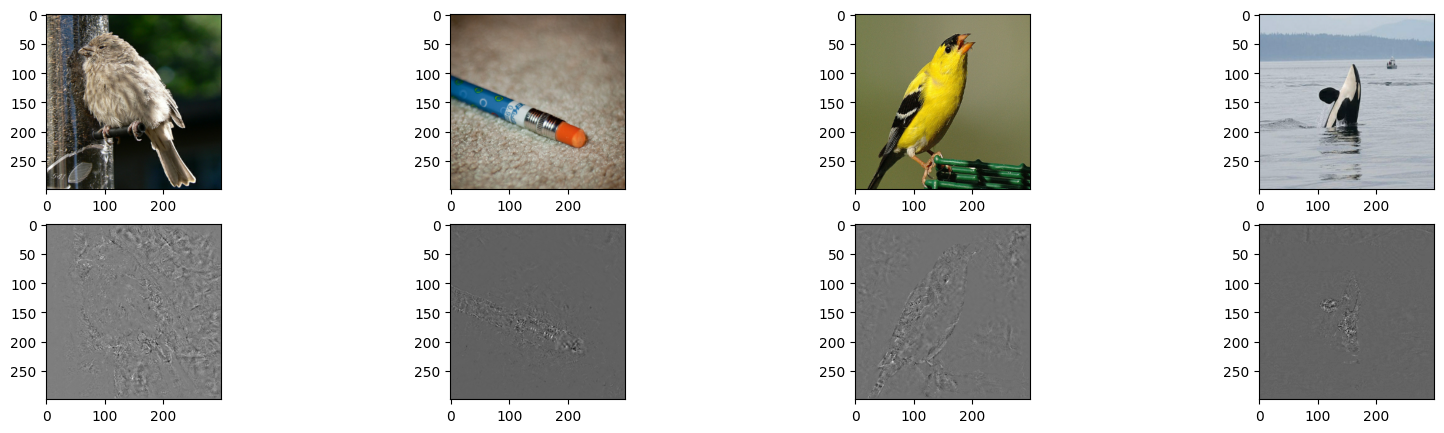

In [20]:
# Plot integrated gradients reults for all images
fig, axs = plt.subplots(2, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])

    saliency_map = integrated_gradients(model, input_tensor, target_class).squeeze(0)
    saliency_img = torch.tensor(saliency_map).permute(1, 2, 0).numpy().mean(axis=2)
    axs[0, i].imshow(utils.normalize(image))
    axs[1, i].imshow(utils.normalize(saliency_img), cmap="gray", alpha=1)

**4 | Change the baseline and comment on the results—do they change?**

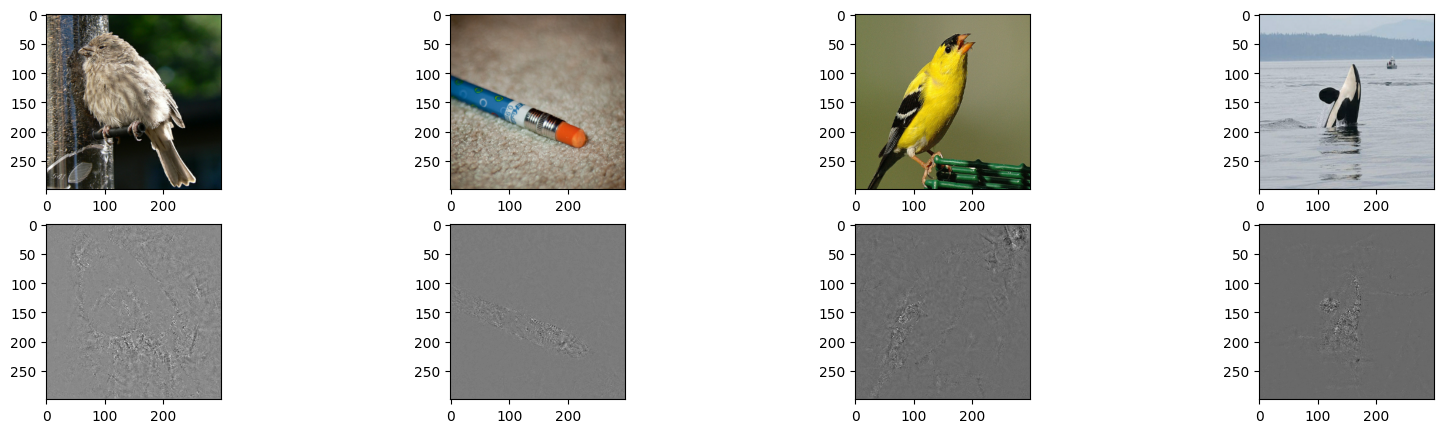

In [19]:
# Use a different baseline of all ones
fig, axs = plt.subplots(2, images.shape[0], figsize=(5 * images.shape[0], 5))

rand_baseline = torch.rand_like(input_tensor)

for i, image in enumerate(images):
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])

    saliency_map = integrated_gradients(model, input_tensor, target_class, rand_baseline).squeeze(0)
    saliency_img = torch.tensor(saliency_map).permute(1, 2, 0).numpy().mean(axis=2)
    axs[0, i].imshow(utils.normalize(image))
    axs[1, i].imshow(utils.normalize(saliency_img), cmap="gray", alpha=1)

**5 | Suggest an explanation for your observation if the results are different and suggest an alternative method.**

In [ ]:
# YOUR EXPLANATION HERE

**6 | Compare your results by implementing Captum's `IntegratedGradients` method.**

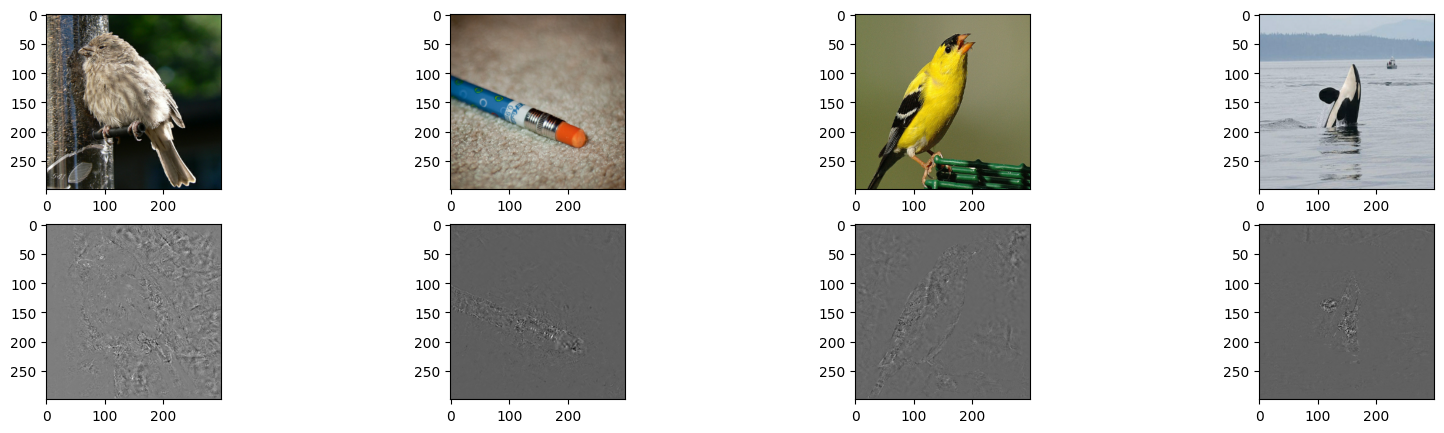

In [18]:
# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Plot Integrated Gradients reults from Captum library for all images
fig, axs = plt.subplots(2, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert your numpy image to a PyTorch tensor of shape (1, C, H, W)
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()

    # The target class label for the corresponding image
    target_class = int(labels[i])

    # Compute the saliency map using Integrated Gradients
    attributions = ig.attribute(input_tensor, target=target_class)

    # Convert the attributions to a numpy array and average over color channels if necessary
    saliency_map = attributions.squeeze().cpu().detach().numpy().mean(axis=0)

    # Plot the original image and the saliency map
    axs[0, i].imshow(utils.normalize(image))
    axs[1, i].imshow(utils.normalize(saliency_map), cmap="gray", alpha=1)

plt.show()

## Occlusion

**1 | Use Captum's built-in occlusion functionality to derive and plot saliency maps for all images.**

In [ ]:
# Initialize Occlusion
occlusion = Occlusion(model)

# Plot occlusion reults for all images
fig, axs = plt.subplots(2, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images[:1]):
    # Convert your numpy image to a PyTorch tensor of shape (1, C, H, W)
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()

    # The target class label for the corresponding image
    target_class = int(labels[i])

    # Compute the saliency map using Integrated Gradients
    attributions = occlusion.attribute(input_tensor,   sliding_window_shapes=(3, 32, 3), target=target_class)

    # Convert the attributions to a numpy array and average over color channels if necessary
    saliency_map = attributions.squeeze().cpu().detach().numpy().mean(axis=0)

    # Plot the original image and the saliency map
    axs[0, i].imshow(utils.normalize(image))
    axs[1, i].imshow(utils.normalize(saliency_map), cmap="gray", alpha=1)

plt.show()

**2 | Analyze how different window sizes affect your results and discuss how you would determine the optimal size.**

In [ ]:
# YOUR EXPLANATION HERE

## Grad-CAM

**1 | Use your theoretical knowledge of Grad-CAM to write a simple attribution method that returns a saliency map.**

In [ ]:
class GradCAM:

    def __init__(self, model, target_layer):
        self.model = model  # The model for which to generate GradCAM
        self.target_layer = target_layer  # The target layer in the model for which to generate GradCAM
        self.gradients = None  # The gradients of the target layer
        self.activations = None  # The activations of the target layer
        self._register_hooks()  # Registers forward and backward hooks to capture activations and gradients of the target layer
        # To understand hooks, see: https://www.youtube.com/watch?v=syLFCVYua6Q
        # As well as the PyTorch documentation https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks

    def _register_hooks(self):
        # This function registers forward hooks to capture activations of the target layer
        # In this case, the small feature maps of the last convolutional layer that will be weighted by the gradients and upsampled to generate a CAM
        def forward_hook(module, input, output):
            self.activations = output  # shape (batch, channels, height, width)

        def backward_hook(module, grad_in, grad_out):
            # This function registers backward hooks to capture gradients of the target layer necesary to weight the above activations
            self.gradients = grad_out[
                0]  # we select the first element of the grad_out tuple because it contains the gradients, the second element contains the biases

        self.target_layer.register_forward_hook(forward_hook)  # register forward hook
        self.target_layer.register_backward_hook(backward_hook)  # register backward hook

    def generate_cam(self, input_tensor, target_class):
        self.model.zero_grad()  # zero the gradients

        # YOUR CODE HERE

        return cam

**2 | Plot the saliency maps for all images.**

In [5]:
# YOUR CODE HERE

**3 | Use a few different target layers and report on how the saliency map changes with model depth.**

In [6]:
# YOUR EXPLANATION HERE

**4 | Compare your results by implementing Captum's `LayerGradCam` method.**

In [7]:
# YOUR CODE HERE